# Modelando la Pandemia

  En este proyecto vamos a estudiar y analizar los datos mundiales de la pandemia COVID-19 usando países modelo de distintas políticas públicas para luego interpretar otras curvas.

Puedes descargar el dataset de casos totales, divididos por país [aquí.](
https://ourworldindata.org/coronavirus-data?country=
) Descarga los datos  formato .csv luego podrás cargarlos en el notebook usando pandas, a partir de eso selecciona los de los países que te interesan, hay un ejemplo de cómo se hace esto en este notebook. 

# ¿Cómo empezó la pandemia?


  La primer parte del trabajo consiste en estudiar cómo se empieza a propagar la pandemia, luego analizaremos las medidas tomadas y su efectividad.

  Al inicio de una pandemia, se estima que los contagios siguen una ley exponencial, esa es la fase de "crecimiento exponencial", luego hay un decaimiento dado por la inmunidad. 

  Los datos de casos confirmados en función del tiempo $C(t)$, pueden aproximarse con el modelo

$C(t)=e^{k(t-t_0)}$

donde $t_0$ es la fecha del primer contagio, y $k$ es un parámetro propio de cada enfermedad, que habla de la contagiosidad. Cuanto mayor es $k$, más grande será el número de casos confirmados dado por la expresión. $k$ depende de el tiempo que una persona enferma contagia, el nivel de infecciosidad del virus y cuántas personas que se pueden contagiar ve una persona enferma por día. Es decir, la circulación. Haciendo cuarententa, $k$ disminuye, con la circulación $k$ aumenta.

  El parámetro $k$ está directamente relacionado con el $R$ del que tanto se habla en los medios. En este proyecto haremos foco en $k$, pero puedes profundizar sobre esto si quieres, empezandó por [aquí](https://es.wikipedia.org/wiki/Ritmo_reproductivo_b%C3%A1sico). 

  Es posible hacer un modelo completo, pero para eso es necesario utilizar ecuaciones diferenciales. Si quieres profundizar sobre eso, busca información sobre "modelo epidemiológico SEIR". Si quieres ver cómo funciona este modelo, puedes empezar por [aquí](http://gabgoh.github.io/COVID/index.html). En ese link está implementado el modelo SEIR (no es necesario entender las ecuaciones en este caso) y el rol que cumplen los parámetros, puedes explorar el impacto de variar $R$ y el resto de los valores para ver cómo impactan en la curva de contagios. Ahora utilizaremos la siguiente expresión para describir únicamente la etapa de crecimiento exponencial.


  Comienza estudiando cómo se distribuyó el $k$ inicial de la pandemia y si es posible elaborar un intervalo de confianza razonable para este valor. Para eso 
  
  1. Elegir diez países del norte (ahí empezó la pandemia) y puedes mide el valor de $k$ inicial de la pandemia, analizando datos del primer tramo.

  2. Analiza si es posible estimar la evolución mundial de la pandemia a partir de lo que obtuviste. Para esto, puedes elaborar un intervalo de confianza para $k$ a partir de los que obtuviste y así generar un modelo nuevo, basado en la distribución de $k$. Luego compara el modelo con los datos mundiales.

3. Piensa qué significa que el modelo de "bien" o dé "mal" ¿qué indicadores de esto existen?. Luego discute en el informe por qué crees que dio así. Recuerda que es importante elegir bien la población de muestra. Piensa qué criterios puedes elegir para representar bien la población mundial que se contagió al inicio de la pandemia.
 
 # Evaluando estrategias

 Ahora que tienes una manera de obtener información de las curvas, puedes intentar evaluar las estrategias de acción y el comportamiento de las poblaciones, construyendo un clasificador binario. 
1. Elige una categoría binaria que hable de políticas públicas elegidas por los países para enfrentar la pandemia que te interese estudiar, como pueden ser "la población hizo cuarententa" o "la población se vacunó".
2. Piensa qué indicadores de la curva pueden hablar del éxito de la política que quieres estudiar. Por ejemplo, si se tratase de evaluar el éxito de una cuarentena podría ser porcentaje de población  que se contagió o variación del valor de $k$ a partir de que se empezó a implementar esa medida. Elige al menos 3 indicadores.
3. Investiga sobre países que hayan aplicado o no esa política pública, para generar una base de datos. Por ejemplo, Brasil no hizo cuarentena y China hizo una muy estricta. Recuerda hacer una selección inteligente de la porción de datos de la curva de cada país que vas a analizar.
4. Construye un clasificador binario a partir de una regresión logística o usando Naive Bayes para intentar analizar la estrategia de otros países y ver si es posible predecirla a partir de la curva de contagios y el clasificador. Un posible clasificador binario es uno que clasifique el porcentaje de contagios en función da las categorías "la población hizo cuarentena" y "la población no hizo cuarentena". Haz esto para los 3 indicadores que elegiste en el punto 3 y compara los resultados.
5. Elabora un informe con lo que hayas aprendido a lo largo de este proyecto, donde discutas la utilidad o no de los indicadores que elegiste y del análisis estadístico propuesto.

# ¡Comencemos!

  A continuación dejamos un ejemplo de cómo extraer el $k$ inicial de Argentina, usando un ajuste de cuadrados mínimos. Si necesitas los datos mundiales, en la columna de países aparecen como "World".



In [1]:
import numpy as np
import pandas as pd
import mglearn
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D, axes3d
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from scipy.optimize import curve_fit

import warnings

In [2]:
warnings.filterwarnings(action = 'ignore')

In [3]:
datos = pd.read_csv('owid-covid-data.csv')
datos.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN


In [4]:
datos.columns.unique()

Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'new_tests', 'total_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
       'new_vaccinations', 'new_vaccinations_smoothed',
       't

In [5]:
datos_covid = (datos.loc[:, ['location', 'iso_code', 'date', 'total_tests', 'total_deaths', 'total_cases', 'new_cases']])

datos_covid.columns = ['Entity', 'Code', 'Day', 'Total_test', 'Total_confirmed_death_due_to_Covid19',
                       'Total_confirmed_cases_of_Covid19', 'New_cases_of_Covid19']

datos_covid.head()

,Entity,Code,Day,Total_test,Total_confirmed_death_due_to_Covid19,Total_confirmed_cases_of_Covid19,New_cases_of_Covid19
0,Afghanistan,AFG,2020-02-24,NaN,NaN,5.0,5.0
1,Afghanistan,AFG,2020-02-25,NaN,NaN,5.0,0.0
2,Afghanistan,AFG,2020-02-26,NaN,NaN,5.0,0.0
3,Afghanistan,AFG,2020-02-27,NaN,NaN,5.0,0.0
4,Afghanistan,AFG,2020-02-28,NaN,NaN,5.0,0.0


In [6]:
datos_covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132644 entries, 0 to 132643
Data columns (total 7 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Entity                                132644 non-null  object 
 1   Code                                  132644 non-null  object 
 2   Day                                   132644 non-null  object 
 3   Total_test                            55345 non-null   float64
 4   Total_confirmed_death_due_to_Covid19  114293 non-null  float64
 5   Total_confirmed_cases_of_Covid19      125410 non-null  float64
 6   New_cases_of_Covid19                  125408 non-null  float64
dtypes: float64(4), object(3)
memory usage: 7.1+ MB


In [7]:
datos_covid.describe(include = 'number')

,Total_test,Total_confirmed_death_due_to_Covid19,Total_confirmed_cases_of_Covid19,New_cases_of_Covid19
count,5.534500e+04,1.142930e+05,1.254100e+05,125408.000000
mean,1.190922e+07,5.045250e+04,2.038985e+06,8353.112888
std,4.957836e+07,2.589636e+05,1.163910e+07,43547.802492
min,0.000000e+00,1.000000e+00,1.000000e+00,-74347.000000
25%,2.560430e+05,8.000000e+01,2.388000e+03,3.000000
50%,1.288436e+06,7.410000e+02,2.714850e+04,104.000000
75%,5.281131e+06,6.468000e+03,2.641010e+05,1077.000000
max,6.330199e+08,5.079990e+06,2.519418e+08,907963.000000


In [8]:
datos_covid.describe(exclude = 'number')

,Entity,Code,Day
count,132644,132644,132644
unique,237,237,681
top,Peru,PER,2021-06-23
freq,681,681,234


In [9]:
datos_covid.isna().sum()

Entity                                      0
Code                                        0
Day                                         0
Total_test                              77299
Total_confirmed_death_due_to_Covid19    18351
Total_confirmed_cases_of_Covid19         7234
New_cases_of_Covid19                     7236
dtype: int64

In [10]:
# datos_covid.Entity.unique()

In [11]:
paises = datos_covid['Entity'] # cargo el vector de paises
confirmados = datos_covid['Total_confirmed_cases_of_Covid19'] # carga vector todos los casos confirmados

In [12]:
ind_arg = np.where(paises == 'Argentina')

In [13]:
confirmados[ind_arg[0]].isna().sum()

62

Text(0, 0.5, 'cantidad de casos')

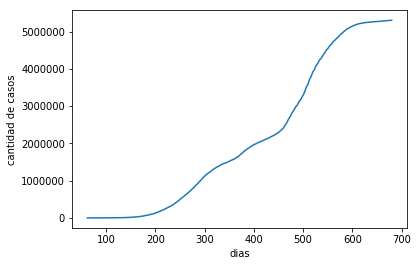

In [14]:
# seleccionamos Argentina

ind_arg = np.where(paises == 'Argentina')
ind_arg = ind_arg[0]
casos_arg = confirmados[ind_arg]
dias = np.arange(0,len(casos_arg))
plt.plot(dias,casos_arg)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')

Esta es la curva de **casos totales** de la Argentina. Aquí no se ven las olas, ya que estas se ven en la curva de casos confirmados por día, es decir, de casos nuevos. Esta habla de los acumulados, entonces siempre se agregan.

Para ver mejor la curva, podemos tomar el logartimo de los datos. Una curva exponencial se ve lineal en escala logarítmica


Text(0, 0.5, 'log cantidad de casos')

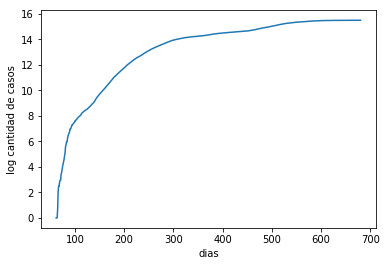

In [15]:
plt.plot(dias,np.log(casos_arg))
plt.xlabel('dias')
plt.ylabel('log cantidad de casos')

Veamos lo que pasa en los primeros 60 días desde que se detectó el primer caso en Argentina, para ver cómo fue el $k$ inicial

In [16]:
min_casos_id = min(casos_arg.index)
max_casos_id = max(casos_arg.index)

Text(0, 0.5, 'cantidad de casos')

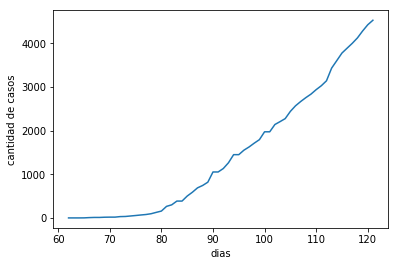

In [17]:
casos_principio = casos_arg[62:122]
dias_principio = dias[62:122]

plt.plot(dias_principio, casos_principio)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')

Es difícil determinar si esta parte es exponencial. Analicemos qué pasa en escala logarítmica.

Text(0, 0.5, 'log cantidad de casos')

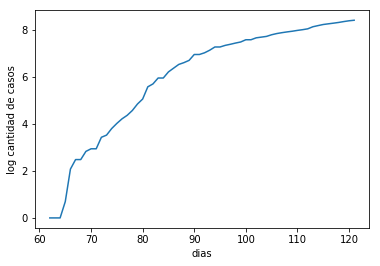

In [18]:

plt.plot(dias_principio,np.log(casos_principio))
plt.xlabel('dias')
plt.ylabel('log cantidad de casos')

Mejor nos quedamos con lo que sucede entre los días 31 y 55, ya que ese fue el comportamiento más sostenido.

Text(0, 0.5, 'cantidad de casos')

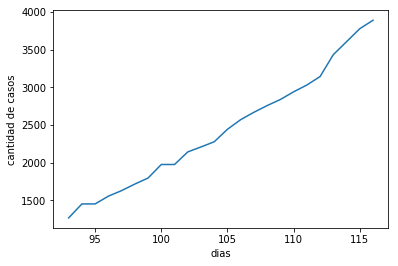

In [19]:
casos_principio=casos_arg[93:117]
dias_principio=dias[93:117]

plt.plot(dias_principio,casos_principio)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')

Text(0, 0.5, 'log cantidad de casos')

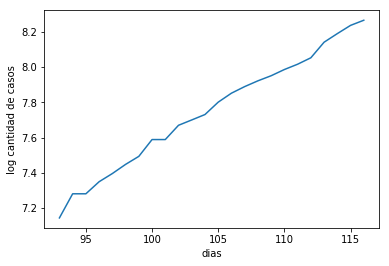

In [20]:
plt.plot(dias_principio,np.log(casos_principio))
plt.xlabel('dias')
plt.ylabel('log cantidad de casos')

¡Se ve bastante lineal! Aprovechemos esto para averiguar el $k$ utilizando un ajuste hecho con el método de cuadrados mínimos, ajustando los datos al modelo 

$Confirmados=e^{k(t-t_0)}$



In [21]:
#definimos función para ajustar modelo
def exponencial(t,k,t0):
    C=np.exp(k*(t-t0))
    return C

In [22]:
#ajustamos
popt, pcov = curve_fit(exponencial, dias_principio, casos_principio)
popt

array([ 4.53529441e-02, -6.64066549e+01])

Veamos cómo se ajusta lo que obtuvimos a los datos reales

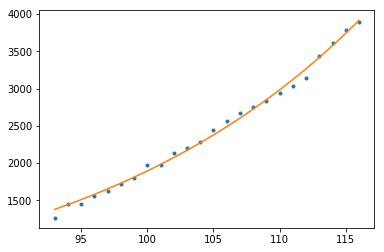

In [23]:
k=popt[0]
t0=popt[1]
casos_simu=exponencial(dias_principio,k,t0)
plt.plot(dias_principio,casos_principio,'.')
plt.plot(dias_principio,casos_simu)

Como última pista, hagamos una función que determine los casos nuevos por día a partir de estas curvas. Puede ser útil para tu análisis.

In [24]:
def casos_nuevos(casos):
    nuevos = np.zeros(len(casos))
    i = 0
    while i < len(nuevos) - 1:
        nuevos[i] = casos[i + 1] - casos[i]
        i = i + 1

    return nuevos

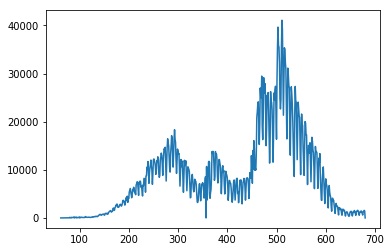

In [25]:
casos_arg=np.array(casos_arg)
nuevos_arg=casos_nuevos(casos_arg)
plt.plot(nuevos_arg)

In [26]:
datos_covid.Entity.unique()

array(['Afghanistan', 'Africa', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Anguilla', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Asia', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bermuda', 'Bhutan', 'Bolivia', 'Bonaire Sint Eustatius and Saba',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'British Virgin Islands', 'Brunei', 'Bulgaria', 'Burkina Faso',
       'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde',
       'Cayman Islands', 'Central African Republic', 'Chad', 'Chile',
       'China', 'Colombia', 'Comoros', 'Congo', 'Cook Islands',
       'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Cuba', 'Curacao',
       'Cyprus', 'Czechia', 'Democratic Republic of Congo', 'Denmark',
       'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Eswatini', 'Ethi

In [27]:
# ['South Korea', 'Japan', 'Italy', 'Germany', 'Spain', 'France', 'Argentina', 'Brazil', 'Colombia', 'United States']
paises_select = ['South Korea', 'Japan', 'Italy', 'Germany', 'Spain', 'France', 'Argentina', 'Brazil', 'Colombia', 'United States']
world_select = ['World']
todo = paises_select + world_select

In [28]:
datos_paises_select = datos_covid[datos_covid['Entity'].isin(paises_select)]

In [29]:
datos_paises_select.isna().sum()

Entity                                     0
Code                                       0
Day                                        0
Total_test                              2698
Total_confirmed_death_due_to_Covid19     309
Total_confirmed_cases_of_Covid19          63
New_cases_of_Covid19                      68
dtype: int64

In [30]:
auxiliar = datos_paises_select['Day'][50:600]
print(auxiliar.min())
print(auxiliar.max())

2020-02-20
2021-08-22


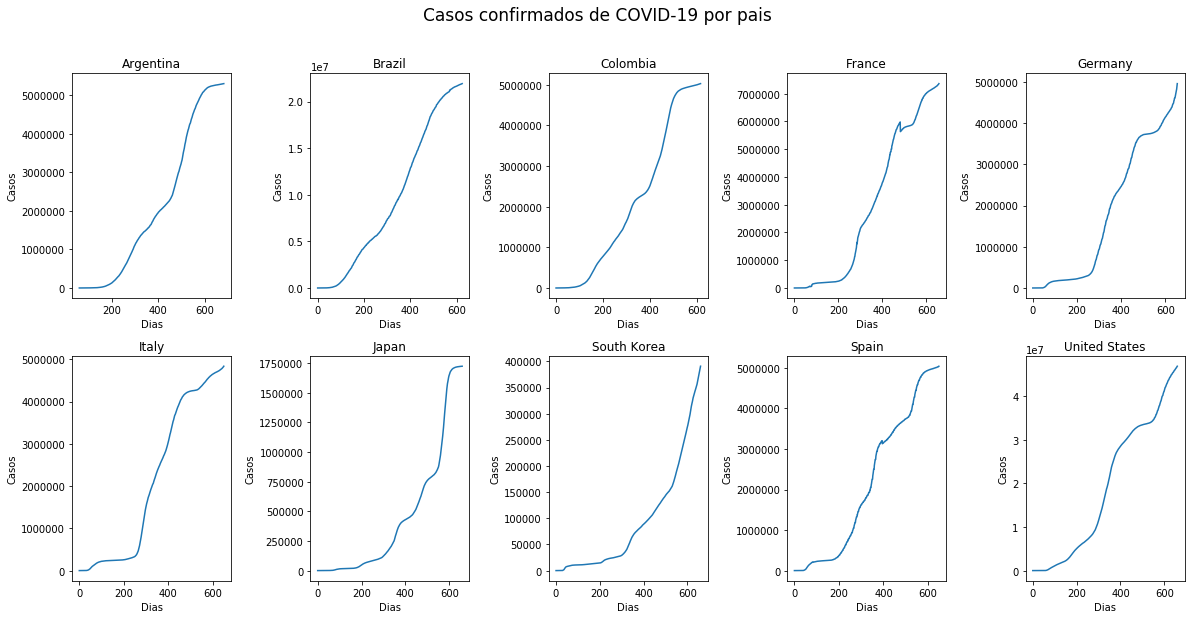

In [31]:
paises = list(datos_paises_select.Entity.unique())

a = 2
b = 5
c = 1

fig, ax = plt.subplots(figsize = (16.7, 8))

for pais in paises:
    ax = plt.subplot(a, b, c)
    casos_conf = datos_paises_select['Total_confirmed_cases_of_Covid19'][(datos_paises_select['Entity'] == pais)]
    dias = np.arange(casos_conf.shape[0])
    ax.plot(dias, casos_conf)
    plt.xlabel('Dias')
    plt.ylabel('Casos')
    plt.title(pais)
    plt.suptitle('Casos confirmados de COVID-19 por pais', fontsize = 17, y = 1.07)
    c = c + 1
    
plt.tight_layout()
plt.show()

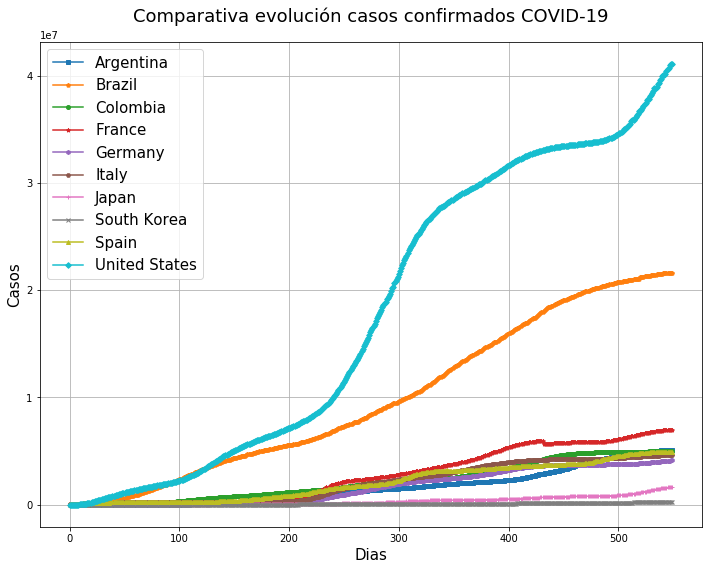

In [32]:
marks = ['s', 'p', 'o', '*', 'h', 'H', '+', 'x', '^', 'D', '.', '*']
i = 0

fig, ax = plt.subplots(figsize = (10, 8))

for pais in paises:
    casos_conf = datos_paises_select['Total_confirmed_cases_of_Covid19'][(datos_paises_select['Entity'] == pais)][50:600]
    dias = np.arange(casos_conf.shape[0])
    ax.plot(dias, casos_conf, label = pais, marker = marks[i], markersize = 4)
    i += 1

plt.grid()
plt.xlabel('Dias', fontsize = 15)
plt.ylabel('Casos', fontsize = 15)
plt.title('Comparativa evolución casos confirmados COVID-19', fontsize = 18, y = 1.03)
ax.legend(fontsize = 15)
plt.tight_layout()
plt.savefig(fname = 'paises_casos.jpg', bbox_inches = 'tight', dpi = 200)
plt.show()

In [33]:
datos_all = datos_covid[datos_covid['Entity'].isin(todo)]

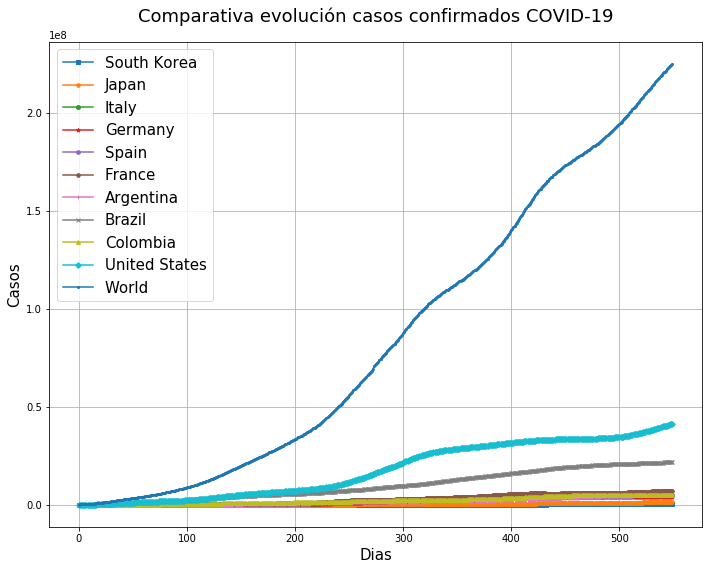

In [34]:
marks = ['s', 'p', 'o', '*', 'h', 'H', '+', 'x', '^', 'D', '.', '*', 's']
i = 0

fig, ax = plt.subplots(figsize = (10, 8))

for pais in todo:
    casos_conf = datos_all['Total_confirmed_cases_of_Covid19'][(datos_all['Entity'] == pais)][50:600]
    dias = np.arange(casos_conf.shape[0])
    ax.plot(dias, casos_conf, label = pais, marker = marks[i], markersize = 4)
    i += 1

plt.grid()
plt.xlabel('Dias', fontsize = 15)
plt.ylabel('Casos', fontsize = 15)
plt.title('Comparativa evolución casos confirmados COVID-19', fontsize = 18, y = 1.03)
ax.legend(fontsize = 15)
plt.tight_layout()
plt.savefig(fname = 'all_casos.jpg', bbox_inches = 'tight', dpi = 200)
plt.show()

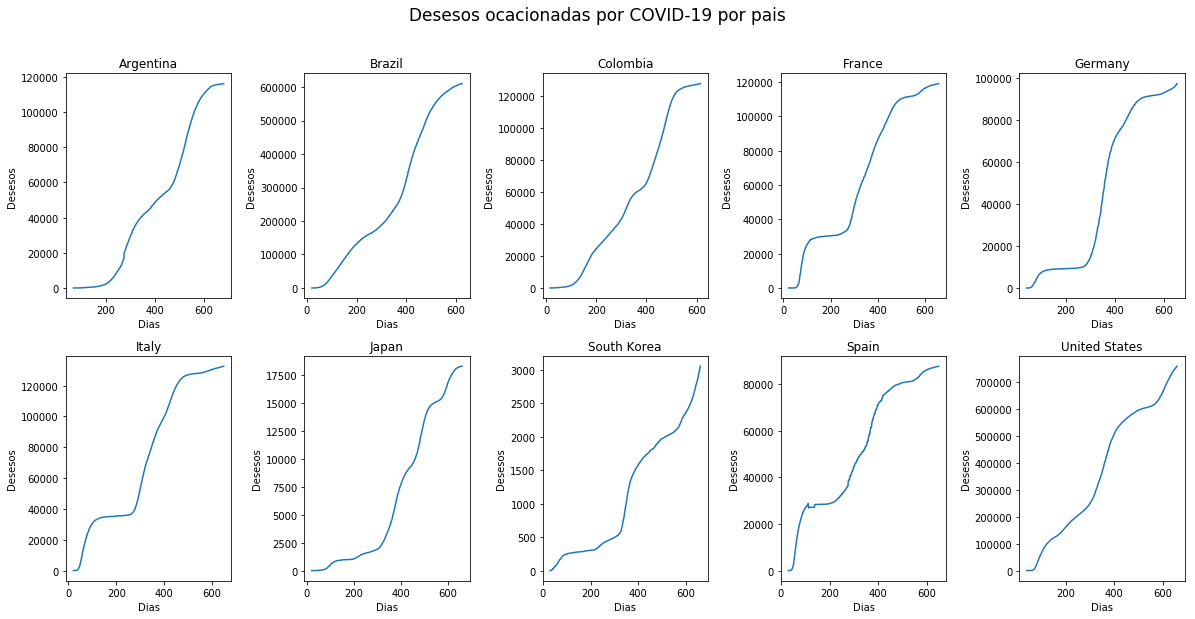

In [35]:
a = 2
b = 5
c = 1

fig, ax = plt.subplots(figsize = (16.7, 8))

for pais in paises:
    ax = plt.subplot(a, b, c)
    casos_conf = datos_paises_select['Total_confirmed_death_due_to_Covid19'][(datos_paises_select['Entity'] == pais)]
    dias = np.arange(casos_conf.shape[0])
    ax.plot(dias, casos_conf)
    plt.xlabel('Dias')
    plt.ylabel('Desesos')
    plt.title(pais)
    plt.suptitle('Desesos ocacionadas por COVID-19 por pais', fontsize = 17, y = 1.07)
    c = c + 1
    
plt.tight_layout()
plt.show()

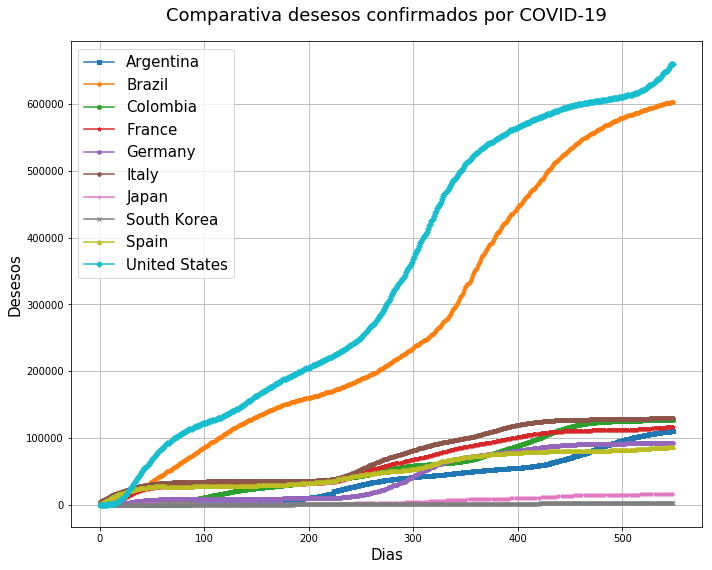

In [36]:
marks = ['s', 'p', 'o', '*', 'h', 'H', '+', 'x', '^', 'D', '.', '*']
i = 0

fig, ax = plt.subplots(figsize = (10, 8))

for pais in paises:
    casos_conf = datos_paises_select['Total_confirmed_death_due_to_Covid19'][(datos_paises_select['Entity'] == pais)][50:600]
    dias = np.arange(casos_conf.shape[0])
    ax.plot(dias, casos_conf, label = pais, marker = marks[i], markersize = 4)
    i += 1

plt.grid()
plt.xlabel('Dias', fontsize = 15)
plt.ylabel('Desesos', fontsize = 15)
plt.title('Comparativa desesos confirmados por COVID-19', fontsize = 18, y = 1.03)
ax.legend(fontsize = 15)
plt.tight_layout()
plt.savefig(fname = 'paises_muertes.jpg', bbox_inches = 'tight', dpi = 200)
plt.show()

In [37]:
datos_world = datos_covid[datos_covid['Entity'].isin(world_select)]

In [38]:
datos_world.shape

(660, 7)

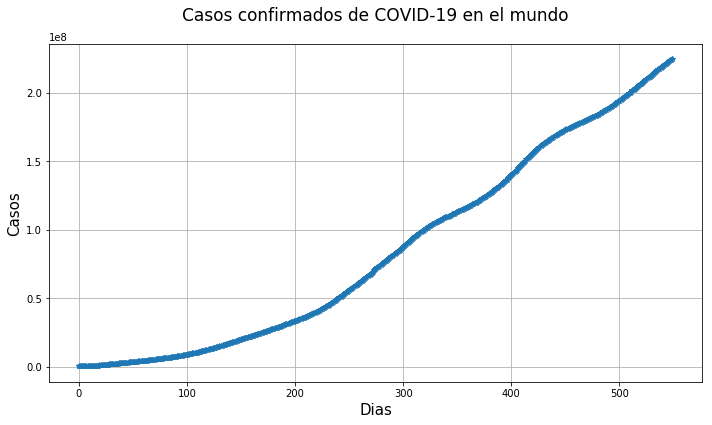

In [39]:
fig, ax = plt.subplots(figsize = (10, 6))
casos_conf = datos_world['Total_confirmed_cases_of_Covid19'][50:600]
dias = np.arange(casos_conf.shape[0])
plt.plot(dias, casos_conf, linewidth = 4, marker = '*')
plt.xlabel('Dias', fontsize = 15)
plt.ylabel('Casos', fontsize = 15)
plt.title('Casos confirmados de COVID-19 en el mundo', fontsize = 17, y = 1.05)
plt.grid()
plt.tight_layout()
plt.savefig(fname = 'mundo_casos.jpg', bbox_inches = 'tight', dpi = 200)
plt.show()

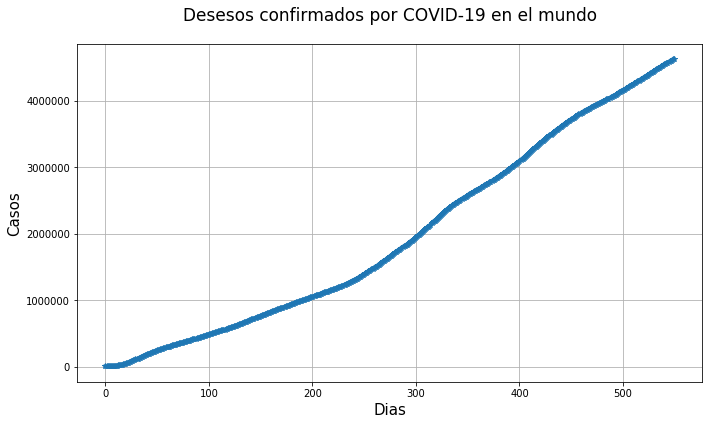

In [40]:
fig, ax = plt.subplots(figsize = (10, 6))
casos_conf = datos_world['Total_confirmed_death_due_to_Covid19'][50:600]
dias = np.arange(casos_conf.shape[0])
plt.plot(dias, casos_conf, linewidth = 4, marker = '*')
plt.xlabel('Dias', fontsize = 15)
plt.ylabel('Casos', fontsize = 15)
plt.title('Desesos confirmados por COVID-19 en el mundo', fontsize = 17, y = 1.05)
plt.grid()
plt.tight_layout()
plt.savefig(fname = 'mundo_muertes.jpg', bbox_inches = 'tight', dpi = 200)
plt.show()

In [41]:
datos_paises_select['Tasa_mortalidad'] = round(
    (datos_paises_select['Total_confirmed_death_due_to_Covid19'] / datos_paises_select['Total_confirmed_cases_of_Covid19']) * 100, 3)

datos_world['Tasa_mortalidad'] = round((datos_world['Total_confirmed_death_due_to_Covid19'] / datos_world['Total_confirmed_cases_of_Covid19']) * 100, 3)

In [42]:
print(display(datos_paises_select.tail(3)))
print(display(datos_world.tail(3)))

,Entity,Code,Day,Total_test,Total_confirmed_death_due_to_Covid19,Total_confirmed_cases_of_Covid19,New_cases_of_Covid19,Tasa_mortalidad
125837,United States,USA,2021-11-09,NaN,757291.0,46693102.0,79820.0,1.622
125838,United States,USA,2021-11-10,NaN,758916.0,46789031.0,95929.0,1.622
125839,United States,USA,2021-11-11,NaN,759676.0,46852276.0,63245.0,1.621


None


,Entity,Code,Day,Total_test,Total_confirmed_death_due_to_Covid19,Total_confirmed_cases_of_Covid19,New_cases_of_Covid19,Tasa_mortalidad
130854,World,OWID_WRL,2021-11-09,NaN,5064332.0,250847485.0,479289.0,2.019
130855,World,OWID_WRL,2021-11-10,NaN,5072444.0,251420477.0,572992.0,2.018
130856,World,OWID_WRL,2021-11-11,NaN,5079990.0,251941758.0,521281.0,2.016


None


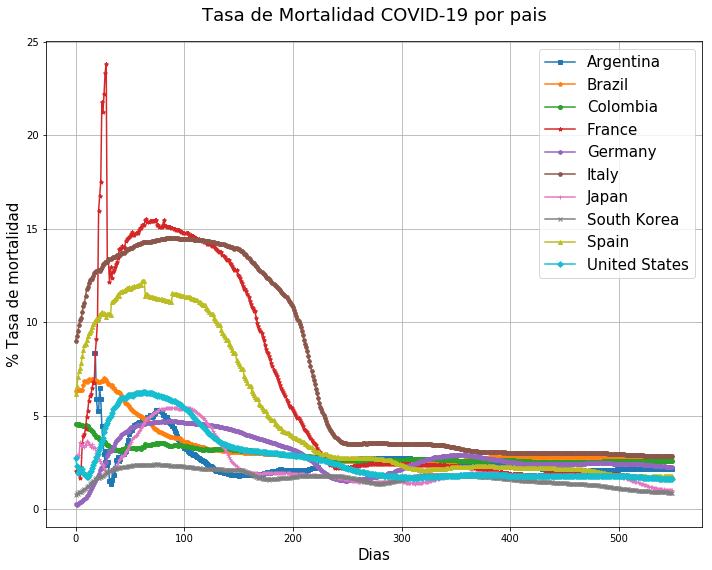

In [43]:
marks = ['s', 'p', 'o', '*', 'h', 'H', '+', 'x', '^', 'D', '.', '*']
i = 0

fig, ax = plt.subplots(figsize = (10, 8))

for pais in paises:
    casos_conf = datos_paises_select['Tasa_mortalidad'][(datos_paises_select['Entity'] == pais)][50:600]
    dias = np.arange(casos_conf.shape[0])
    ax.plot(dias, casos_conf, label = pais, marker = marks[i], markersize = 4)
    i += 1

plt.grid()
plt.xlabel('Dias', fontsize = 15)
plt.ylabel('% Tasa de mortalidad', fontsize = 15)
plt.title('Tasa de Mortalidad COVID-19 por pais', fontsize = 18, y = 1.03)
ax.legend(fontsize = 15)
plt.tight_layout()
plt.savefig(fname = 'paises_mortalidad.jpg', bbox_inches = 'tight', dpi = 200)
plt.show()

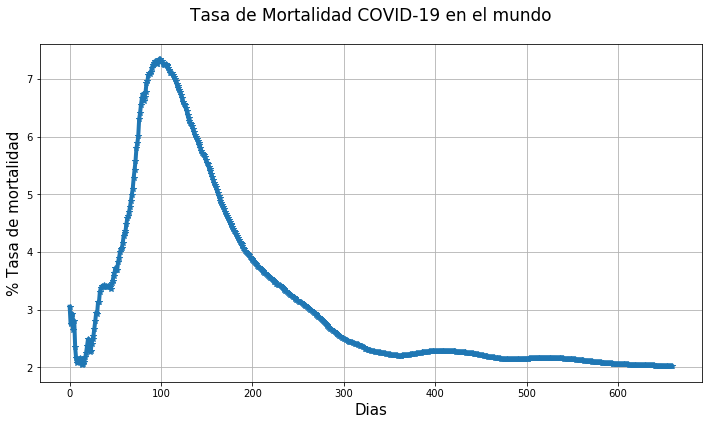

In [44]:
fig, ax = plt.subplots(figsize = (10, 6))
casos_conf = datos_world['Tasa_mortalidad']
dias = np.arange(casos_conf.shape[0])
plt.plot(dias, casos_conf, linewidth = 4, marker = '*')
plt.xlabel('Dias', fontsize = 15)
plt.ylabel('% Tasa de mortalidad', fontsize = 15)
plt.title('Tasa de Mortalidad COVID-19 en el mundo', fontsize = 17, y = 1.05)
plt.grid()
plt.tight_layout()
plt.savefig(fname = 'mundo_mortalidad.jpg', bbox_inches = 'tight', dpi = 200)
plt.show()

In [45]:
paises_select.sort()
paises_select

['Argentina',
 'Brazil',
 'Colombia',
 'France',
 'Germany',
 'Italy',
 'Japan',
 'South Korea',
 'Spain',
 'United States']

In [46]:
dias_sk = np.arange(200, 301)
dias_ja = np.arange(150, 251)
dias_it = np.arange(200, 301)
dias_ge = np.arange(250, 351)
dias_sp = np.arange(150, 251)
dias_fr = np.arange(200, 301)
dias_ar = np.arange(200, 301)
dias_br = np.arange(100, 201)
dias_co = np.arange(200, 301)
dias_us = np.arange(200, 301)
dias_wo = np.arange(200, 301)

In [47]:
casos_sk = datos_paises_select['Total_confirmed_cases_of_Covid19'][(datos_paises_select.Entity == 'South Korea')][200:301]
casos_ja = datos_paises_select['Total_confirmed_cases_of_Covid19'][(datos_paises_select.Entity == 'Japan')][150:251]
casos_it = datos_paises_select['Total_confirmed_cases_of_Covid19'][(datos_paises_select.Entity == 'Italy')][200:301]
casos_ge = datos_paises_select['Total_confirmed_cases_of_Covid19'][(datos_paises_select.Entity == 'Germany')][250:351]
casos_sp = datos_paises_select['Total_confirmed_cases_of_Covid19'][(datos_paises_select.Entity == 'Spain')][150:251]
casos_fr = datos_paises_select['Total_confirmed_cases_of_Covid19'][(datos_paises_select.Entity == 'France')][200:301]
casos_ar = datos_paises_select['Total_confirmed_cases_of_Covid19'][(datos_paises_select.Entity == 'Argentina')][200:301]
casos_br = datos_paises_select['Total_confirmed_cases_of_Covid19'][(datos_paises_select.Entity == 'Brazil')][100:201]
casos_co = datos_paises_select['Total_confirmed_cases_of_Covid19'][(datos_paises_select.Entity == 'Colombia')][200:301]
casos_us = datos_paises_select['Total_confirmed_cases_of_Covid19'][(datos_paises_select.Entity == 'United States')][200:301]
casos_wo = datos_world['Total_confirmed_cases_of_Covid19'][(datos_world.Entity == 'World')][200:301]

In [48]:
popt_sk, pcov_sk = curve_fit(exponencial, dias_sk, casos_sk, maxfev = 2000)
popt_ja, pcov_ja = curve_fit(exponencial, dias_ja, casos_ja, maxfev = 2000)
popt_it, pcov_it = curve_fit(exponencial, dias_it, casos_it, maxfev = 2000)
popt_ge, pcov_ge = curve_fit(exponencial, dias_ge, casos_ge, maxfev = 2000)
popt_sp, pcov_sp = curve_fit(exponencial, dias_sp, casos_sp, maxfev = 2000)
popt_fr, pcov_fr = curve_fit(exponencial, dias_fr, casos_fr, maxfev = 2000)
popt_ar, pcov_ar = curve_fit(exponencial, dias_ar, casos_ar, maxfev = 2000)
popt_br, pcov_br = curve_fit(exponencial, dias_br, casos_br, maxfev = 2000)
popt_co, pcov_co = curve_fit(exponencial, dias_co, casos_co, maxfev = 2000)
popt_us, pcov_us = curve_fit(exponencial, dias_us, casos_us, maxfev = 2000)
popt_wo, pcov_wo = curve_fit(exponencial, dias_wo, casos_wo, maxfev = 2000)

k_paises = [popt_sk[0], popt_ja[0], popt_it[0], popt_ge[0], popt_sp[0], popt_fr[0], popt_ar[0], popt_br[0], popt_co[0], popt_us[0]]
k_world = [popt_wo[0]]

In [49]:
print(k_paises, '\n', k_world)

[0.00552726701289138, 0.0156682083429243, 0.02672601257327274, 0.01774666123085513, 0.015047773299200658, 0.02560388230603602, 0.018684625293643908, 0.015468429672576925, 0.007215974839973763, 0.0076357120882629805] 
 [0.00998018867377126]


In [50]:
popt_co[0]

0.007215974839973763

In [51]:
def remuestreo(datos):
    remuestra = np.zeros(len(datos))
    i = 0
    while i < len(datos):
        remuestra[i] = datos[np.random.randint(len(datos))] # eleccion azarosa de k en funcion de `datos[pais]`
        i = i + 1

    return remuestra

In [52]:
np.random.seed(42)
n_rep = 300
k = k_paises
medias = []

for i in np.arange(n_rep):
    remuestras = remuestreo(k)
    medias.append(np.mean(remuestras))

media_muestra = np.mean(medias)
std_muestra = np.std(medias)
print(media_muestra, '\n', std_muestra)

0.015481674704845938 
 0.0021856117577015322


In [53]:
z = 1.96
n = len(medias)
int_conf = [media_muestra - z * std_muestra / np.sqrt(n), media_muestra + z * std_muestra / np.sqrt(n)]
print(int_conf)

[0.015234349451661952, 0.015728999958029923]


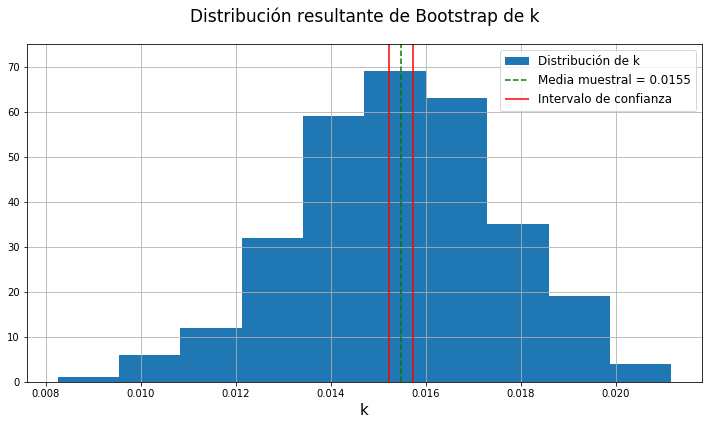

In [54]:
fig, ax = plt.subplots(figsize = (10, 6))

plt.hist(medias, histtype = 'stepfilled', label = 'Distribución de k')
plt.vlines(media_muestra, 0, 75, colors = 'green', linestyles = 'dashed', label = f'Media muestral = {round(media_muestra, 4)}')
plt.vlines(int_conf[0], 0, 75, colors = 'red', label = 'Intervalo de confianza')
plt.vlines(int_conf[1], 0, 75, colors = 'red')
# plt.vlines(np.percentile(medias, 2.5), 0, 75, color = 'yellow')
# plt.vlines(np.percentile(medias, 97.5), 0, 75, color = 'yellow')
plt.xlabel('k', fontsize = 15)
plt.ylim(0, 75)
plt.title('Distribución resultante de Bootstrap de k', fontsize = 17, y = 1.05)
plt.legend(fontsize = 12)
plt.grid()
plt.tight_layout()
plt.savefig(fname = 'distribucion_k.jpg', bbox_inches = 'tight', dpi = 200)
plt.show()

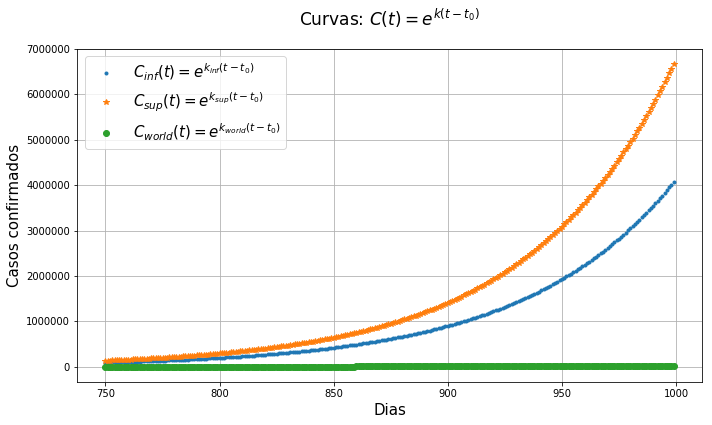

In [55]:
k_min = int_conf[0]
k_max = int_conf[1]

dias_principio = np.arange(750, 1000)

casos_simu_min = exponencial(dias_principio, k_min, 0)
casos_simu_max = exponencial(dias_principio, k_max, 0)
casos_simu_world = exponencial(dias_principio, k_world, 0)

fig, ax = plt.subplots(figsize = (10, 6))

plt.plot(dias_principio, casos_simu_min, '.', label = '$C_{inf}(t)=e^{k_{inf}(t-t_0)}$')
plt.plot(dias_principio, casos_simu_max, '*', label = '$C_{sup}(t)=e^{k_{sup}(t-t_0)}$')
plt.plot(dias_principio, casos_simu_world, 'o', label = '$C_{world}(t)=e^{k_{world}(t-t_0)}$')
plt.title('Curvas: $C(t)=e^{k(t-t_0)}$', fontsize = 17, y = 1.05)
plt.xlabel('Dias', fontsize = 15)
plt.ylabel('Casos confirmados', fontsize = 15)
plt.legend(fontsize = 15)
plt.grid()
plt.tight_layout()
plt.savefig(fname = 'curvas_C.jpg', bbox_inches = 'tight', dpi = 200)
plt.show()

# PARTE B

In [56]:
datos_cuarentena = pd.read_csv('stay-at-home-covid.csv')

In [57]:
datos_cuarentena.head()

,Entity,Code,Day,stay_home_requirements
0,Afghanistan,AFG,2020-01-01,0
1,Afghanistan,AFG,2020-01-02,0
2,Afghanistan,AFG,2020-01-03,0
3,Afghanistan,AFG,2020-01-04,0
4,Afghanistan,AFG,2020-01-05,0


In [58]:
cuar_max = datos_cuarentena[datos_cuarentena['Entity'] == 'Argentina']['Day'].max()
cuar_min = datos_cuarentena[datos_cuarentena['Entity'] == 'Argentina']['Day'].min()

print(cuar_max, cuar_min)

2022-01-24 2020-01-01


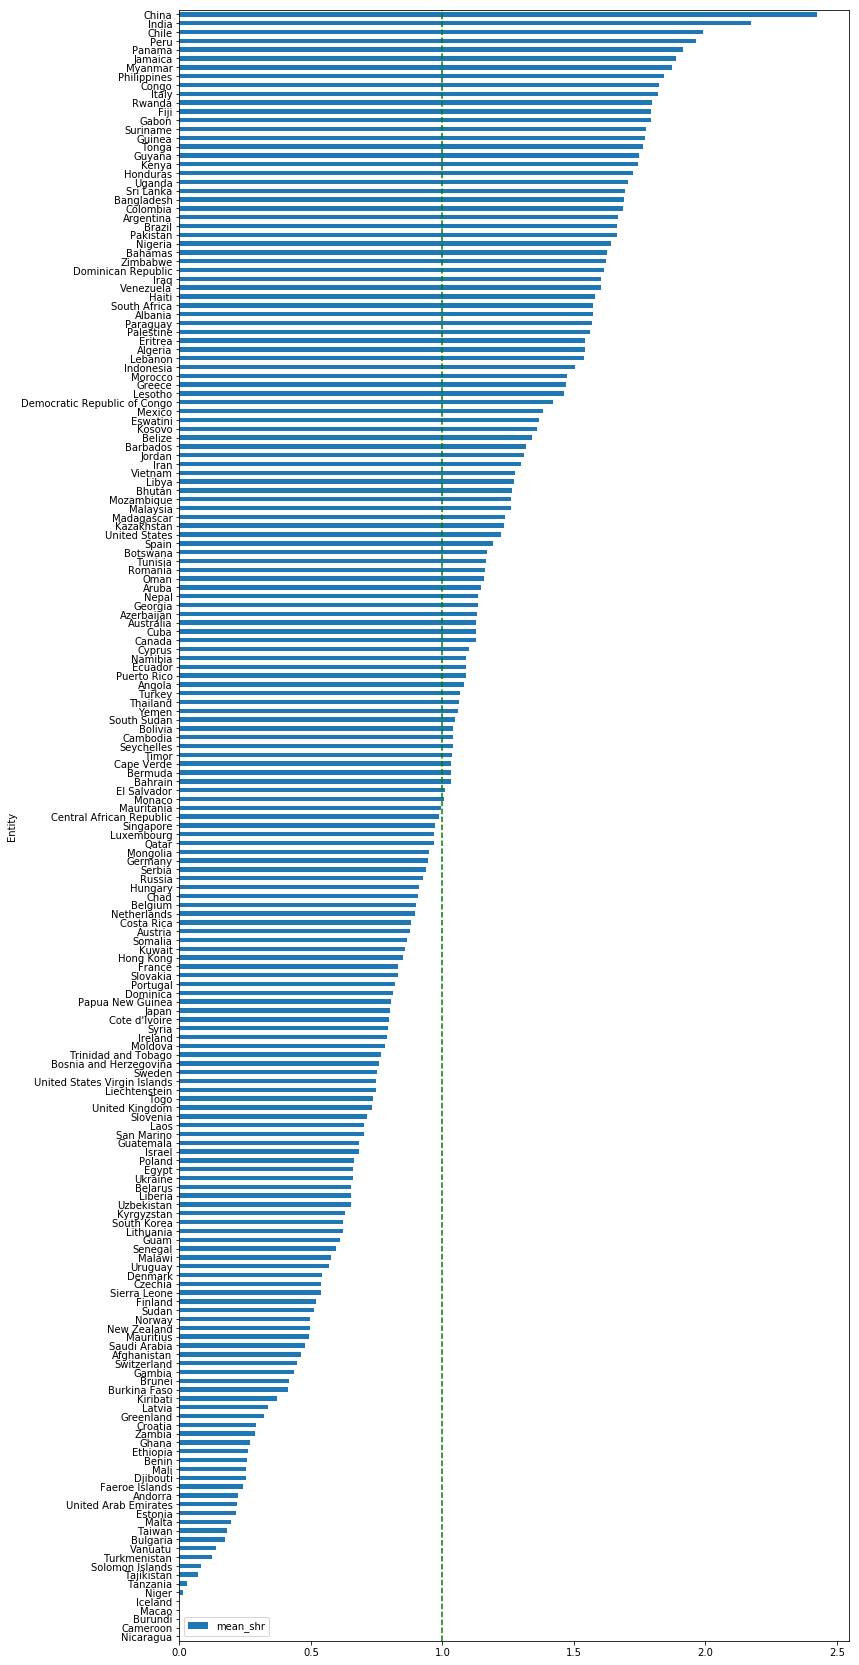

In [59]:
data = datos_cuarentena['stay_home_requirements'].groupby(datos_cuarentena['Entity']).mean().reset_index(
       name = 'mean_shr').sort_values(by = 'mean_shr', ascending = True)

fig, ax = plt.subplots(figsize = (12, 30))
data.plot('Entity', 'mean_shr', kind = 'barh', ax = ax)
ax.axvline(1, color = 'g', linestyle = 'dashed')
plt.show()

In [60]:
paises_no = ['Japan', 'Sweden', 'South Korea', 'Uruguay', 'Israel', 'United Arab Emirates', 'Belgium', 'Norway', 'Switzerland', 'New Zealand']
paises_si = ['India', 'Argentina', 'Italy', 'Chile', 'Greece', 'Jamaica', 'Panama', 'Colombia', 'Rwanda', 'Bangladesh']

all_paises = paises_no + paises_si

cuarentena = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

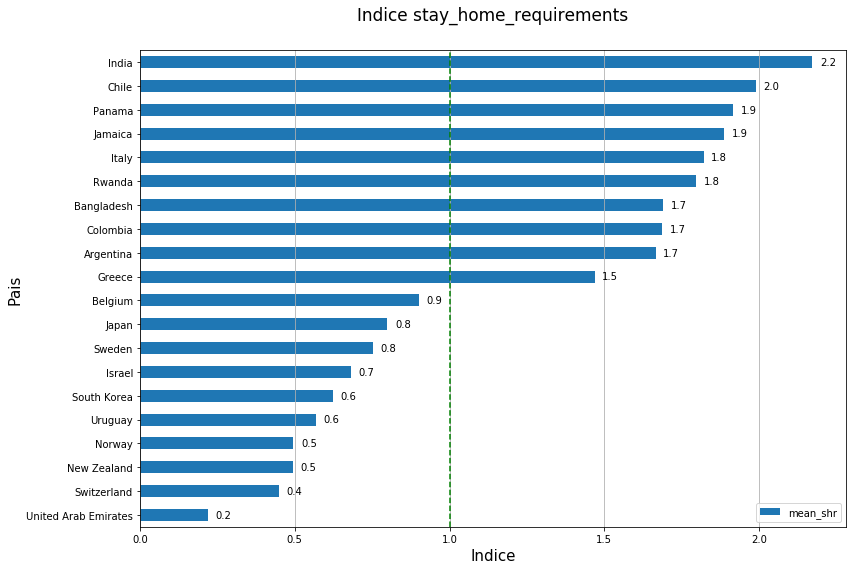

In [61]:
data = data[data['Entity'].isin(all_paises)]

fig, ax = plt.subplots(figsize = (12, 8))
plot = data.plot('Entity', 'mean_shr', kind = 'barh', ax = ax)
ax.axvline(1, color = 'g', linestyle = 'dashed')
for p in plot.patches:
    width = p.get_width()
    plot.text(p.get_width() + 0.05, p.get_y() + p.get_height() / 2,
             '{:1.1f}'.format(width),
             ha = 'center', va = 'center')
plt.xlabel('Indice', fontsize = 15)
plt.ylabel('Pais', fontsize = 15)
plt.title('Indice stay_home_requirements', fontsize = 17, y = 1.05)
plt.grid(axis = 'x')
plt.tight_layout()
plt.savefig(fname = 'indice_stay_home_2.jpg', bbox_inches = 'tight', dpi = 200)
plt.show()

In [62]:
datos_covid_2 = (datos.loc[:, ['location', 'date', 'total_deaths_per_million', 'total_cases_per_million', 'gdp_per_capita']])

datos_covid_2.columns = ['Entity', 'Day', 'total_deaths_per_mill', 'total_cases_per_mill', 'gdp_per_capita']

datos_covid_2.head()

,Entity,Day,total_deaths_per_mill,total_cases_per_mill,gdp_per_capita
0,Afghanistan,2020-02-24,NaN,0.126,1803.987
1,Afghanistan,2020-02-25,NaN,0.126,1803.987
2,Afghanistan,2020-02-26,NaN,0.126,1803.987
3,Afghanistan,2020-02-27,NaN,0.126,1803.987
4,Afghanistan,2020-02-28,NaN,0.126,1803.987


In [63]:
datos_paises_ml = datos_covid_2[datos_covid_2['Entity'].isin(all_paises)]

datos_paises_ml.head()

,Entity,Day,total_deaths_per_mill,total_cases_per_mill,gdp_per_capita
4623,Argentina,2020-01-01,NaN,NaN,18933.907
4624,Argentina,2020-01-02,NaN,NaN,18933.907
4625,Argentina,2020-01-03,NaN,NaN,18933.907
4626,Argentina,2020-01-04,NaN,NaN,18933.907
4627,Argentina,2020-01-05,NaN,NaN,18933.907


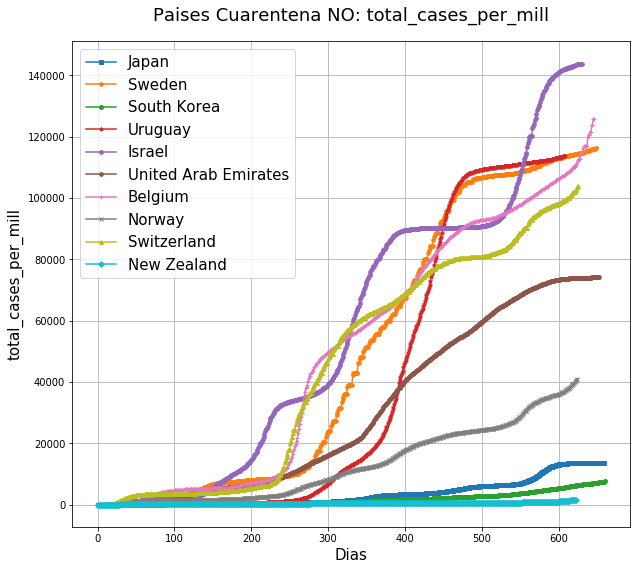

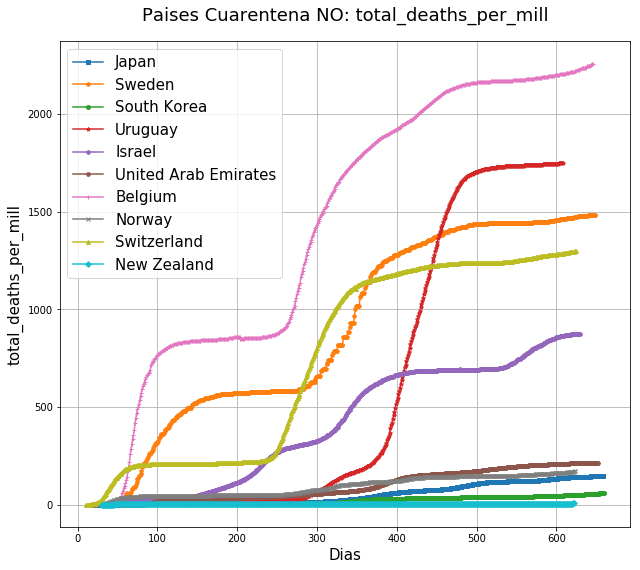

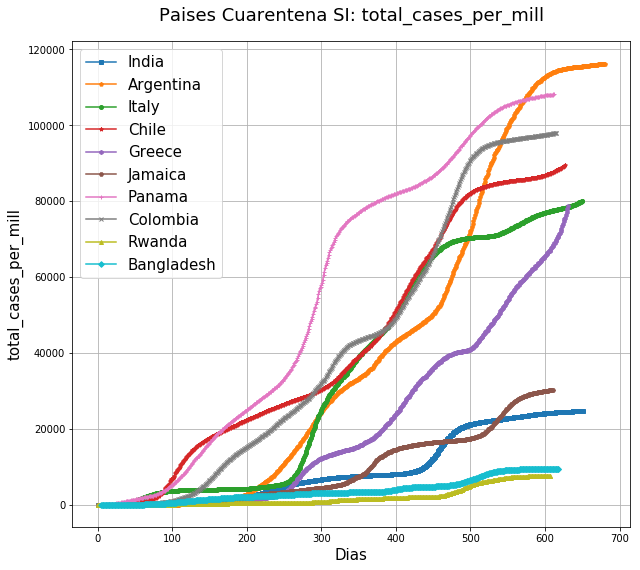

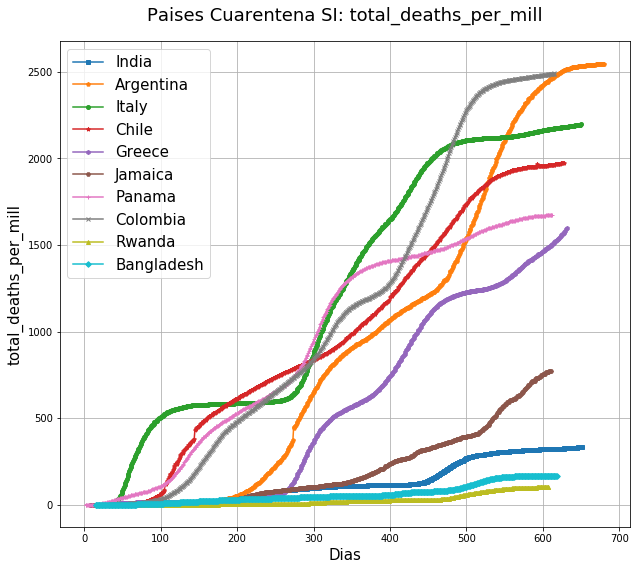

In [64]:
cols = ['total_cases_per_mill', 'total_deaths_per_mill']

marks = ["s","p","o","*","h","H","+","x","^","D","s","p","o","*","h","H","+","x","^","D"]
i = 0

for col in cols:
    fig, ax = plt.subplots(figsize = (9, 8))
    for pais in paises_no:
        casos = datos_paises_ml[col][(datos_paises_ml['Entity'] == pais)]
        dias = np.arange(casos.shape[0])
        plt.plot(dias, casos, label = pais, marker = marks[i], markersize = 4)
        plt.grid(b = True)
        plt.xlabel('Dias', fontsize = 15)
        plt.ylabel(f'{col}', fontsize = 15)
        plt.title(f'Paises Cuarentena NO: {col}', fontsize = 18, y = 1.03)
        plt.legend(fontsize = 15)
        i += 1
        plt.savefig(fname = f'paises_{col}_no_2.jpg', bbox_inches = 'tight', dpi = 200)
    
    plt.tight_layout()
    plt.show()
print('\n')


i = 0

for col in cols:
    fig, ax = plt.subplots(figsize = (9, 8))
    for pais in paises_si:
        casos = datos_paises_ml[col][datos_paises_ml['Entity'] == pais]
        dias = np.arange(casos.shape[0])
        plt.plot(dias, casos, label = pais, marker = marks[i], markersize = 4)
        plt.grid(b = True)
        plt.xlabel('Dias', fontsize = 15)
        plt.ylabel(f'{col}', fontsize = 15)
        plt.title(f'Paises Cuarentena SI: {col}', fontsize = 18, y = 1.03)
        plt.legend(fontsize = 15)
        i += 1
        plt.savefig(fname = f'paises_{col}_si_2.jpg', bbox_inches = 'tight', dpi = 200)
    
    plt.tight_layout()
    plt.show()

In [65]:
datos_dic = {'Pais': all_paises,  
            'k_cases_mill': np.zeros(len(all_paises)),
            'ratio_death': np.zeros(len(all_paises)),
            'gdp_per_capita': np.zeros(len(all_paises)), 
            'cuarentena': cuarentena
           }

datos_ml = pd.DataFrame(datos_dic)
datos_ml

,Pais,k_cases_mill,ratio_death,gdp_per_capita,cuarentena
0,Japan,0.0,0.0,0.0,0
1,Sweden,0.0,0.0,0.0,0
2,South Korea,0.0,0.0,0.0,0
3,Uruguay,0.0,0.0,0.0,0
4,Israel,0.0,0.0,0.0,0
5,United Arab Emirates,0.0,0.0,0.0,0
6,Belgium,0.0,0.0,0.0,0
7,Norway,0.0,0.0,0.0,0
8,Switzerland,0.0,0.0,0.0,0
9,New Zealand,0.0,0.0,0.0,0


In [66]:
datos_paises_ml.columns.unique()

Index(['Entity', 'Day', 'total_deaths_per_mill', 'total_cases_per_mill',
       'gdp_per_capita'],
      dtype='object')

In [67]:
i = 0

for pais in all_paises:
    casos = datos_paises_ml['total_cases_per_mill'][datos_paises_ml['Entity'] == pais][200:501]
    muertes = datos_paises_ml['total_deaths_per_mill'][datos_paises_ml['Entity'] == pais][200:501]
    dias = np.arange(200, 501)
    ratio = np.mean(muertes) / np.mean(casos)
    gdp = datos_paises_ml['gdp_per_capita'][datos_paises_ml['Entity'] == pais].mean()
    
    popt_casos, pcov_casos = curve_fit(exponencial, dias, casos, maxfev = 3000)
    
    datos_ml.loc[i, 'k_cases_mill'] = popt_casos[0]
    datos_ml.loc[i, 'ratio_death'] = ratio
    datos_ml.loc[i, 'gdp_per_capita'] = gdp
    i += 1

In [68]:
datos_ml = datos_ml.sample(frac = 1).reset_index(drop = True)
datos_ml

,Pais,k_cases_mill,ratio_death,gdp_per_capita,cuarentena
0,Greece,0.991457,0.030600,24574.382,1
1,Japan,0.990752,0.017195,39002.223,0
2,Rwanda,0.992643,0.012294,1854.211,1
3,Argentina,0.994537,0.024324,18933.907,1
4,Panama,0.992537,0.017110,22267.037,1
5,Chile,0.993688,0.023887,22767.037,1
6,Jamaica,0.990141,0.019389,8193.571,1
7,Norway,0.994903,0.007719,64800.057,0
8,Sweden,0.991777,0.019546,46949.283,0
9,New Zealand,0.993817,0.010989,36085.843,0


In [69]:
num_col = datos_ml.select_dtypes(include = 'number').drop('cuarentena', axis = 1).columns.to_list()
num_col

['k_cases_mill', 'ratio_death', 'gdp_per_capita']

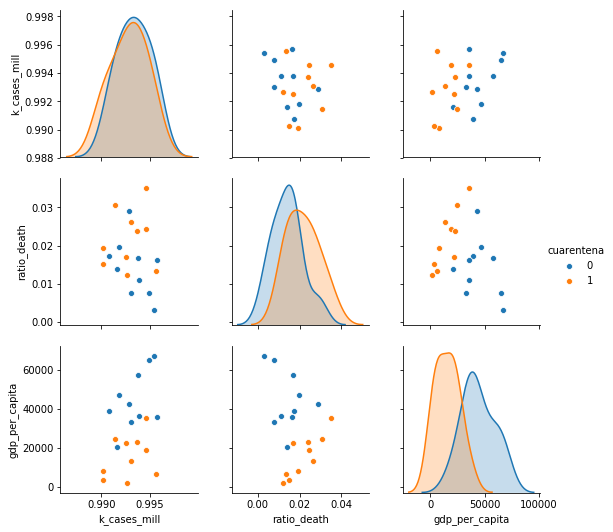

In [70]:
sns.pairplot(data = datos_ml, hue = 'cuarentena', x_vars = num_col, y_vars = num_col)
plt.savefig(fname = 'pairplot.jpg', bbox_inches = 'tight', dpi = 200)
plt.show()

In [71]:
X = datos_ml.drop(['Pais', 'cuarentena'], axis = 1)
y = datos_ml.cuarentena

print(f'X shape: {X.shape} \n y shape: {y.shape}')

X shape: (20, 3) 
 y shape: (20,)


In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, stratify = y)

print(f'X_train shape: {X_train.shape} \n X_test shape: {X_test.shape} \n y_train shape: {y_train.shape} \n y_test shape: {y_test.shape} \n')

X_train shape: (14, 3) 
 X_test shape: (6, 3) 
 y_train shape: (14,) 
 y_test shape: (6,) 



In [73]:
rs_X = RobustScaler()

X_train = rs_X.fit_transform(X_train)
X_test = rs_X.transform(X_test)

In [74]:
param_grid_svm = {'kernel': ['rbf', 'linear', 'poly'],
                  'C': [0.1, 10, 1000],
                  'gamma': [0.001, 0.01, 0.1, 1]
                 }

In [75]:
gridsearch_svm = GridSearchCV(estimator = SVC(random_state = 42), param_grid = param_grid_svm, n_jobs = -1, cv = 5, refit = True,
                              verbose = 2, return_train_score = True)

In [76]:
gridsearch_svm.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5, estimator=SVC(random_state=42), n_jobs=-1,
             param_grid={'C': [0.1, 10, 1000], 'gamma': [0.001, 0.01, 0.1, 1],
                         'kernel': ['rbf', 'linear', 'poly']},
             return_train_score=True, verbose=2)

In [77]:
results_svm = pd.DataFrame(gridsearch_svm.cv_results_)
results_svm = results_svm.sort_values(by = 'rank_test_score')
results_svm.head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
24,0.002156,0.002235,0.001066,0.001678,1000,0.001,rbf,"{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}",1.000000,1.0,...,0.833333,0.210819,1,1.0,0.909091,1.0,1.0,1.0,0.981818,0.036364
18,0.001939,0.000641,0.000599,0.000489,10,0.1,rbf,"{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}",1.000000,1.0,...,0.833333,0.210819,1,1.0,0.909091,1.0,1.0,1.0,0.981818,0.036364
27,0.001012,0.000573,0.000633,0.000859,1000,0.01,rbf,"{'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}",0.666667,1.0,...,0.766667,0.200000,3,1.0,1.000000,1.0,1.0,1.0,1.000000,0.000000


In [78]:
print(gridsearch_svm.best_estimator_)

SVC(C=10, gamma=0.1, random_state=42)


In [79]:
y_predict_svm = gridsearch_svm.predict(X_test)

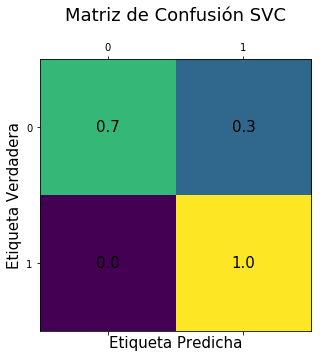

In [108]:
cm = confusion_matrix(y_test, y_predict_svm, normalize = 'true')

fig, ax = plt.subplots(figsize = (5, 5))
ax.matshow(cm)
plt.title('Matriz de Confusión SVC', fontsize = 18, y = 1.12)
plt.ylabel('Etiqueta Verdadera', fontsize = 15)
plt.xlabel('Etiqueta Predicha', fontsize = 15)
for (i, j), z in np.ndenumerate(cm):
    ax.text(j, i, '{:0.1f}'.format(z), ha = 'center', va = 'center', fontsize = 15)
plt.savefig(fname = 'cm_svm.jpg', bbox_inches = 'tight', dpi = 200)
plt.show()

In [107]:
print(classification_report(y_test, y_predict_svm))

              precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       0.75      1.00      0.86         3

    accuracy                           0.83         6
   macro avg       0.88      0.83      0.83         6
weighted avg       0.88      0.83      0.83         6



In [82]:
# model = classifier_svm

# z = lambda x, y: (-model.intercept_[0] - model.coef_[0][0] * x - model.coef_[0][1] * y) / model.coef_[0][2]
# tmp = np.linspace(-2, 2, 30)
# x, y = np.meshgrid(tmp,tmp)

# fig = plt.figure(figsize = (13, 7))
# ax = fig.add_subplot(111, projection = '3d')
# ax.plot3D(X_train[y_train == 0, 0], X_train[y_train == 0, 1], X_train[y_train == 0, 2], 'ob')
# ax.plot3D(X_train[y_train == 1, 0], X_train[y_train == 1, 1], X_train[y_train == 1, 2], 'sr')
# ax.plot_surface(x, y, z(x, y))
# ax.view_init(50, 30)
# plt.title('SVM Clasiffier para frontera de decision de Paises con o sin Cuarentena', fontsize = 18, y = 1.1)
# plt.show()

In [83]:
param_grid_lr = {'penalty': ['l1', 'l2'],
                 'C': [0.1, 10, 1000],
                 'class_weight': [None, 'balanced'],
                 'solver': ['liblinear', 'lbfgs']
                }

In [84]:
gridsearch_lr = GridSearchCV(estimator = LogisticRegression(random_state = 42), param_grid = param_grid_lr, n_jobs = -1, cv = 5, refit = True,
                              verbose = 2, return_train_score = True)

In [85]:
gridsearch_lr.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42), n_jobs=-1,
             param_grid={'C': [0.1, 10, 1000],
                         'class_weight': [None, 'balanced'],
                         'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'lbfgs']},
             return_train_score=True, verbose=2)

In [86]:
results_lr = pd.DataFrame(gridsearch_lr.cv_results_)
results_lr = results_lr.sort_values(by = 'rank_test_score')
results_lr.head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_class_weight,param_penalty,param_solver,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
2,0.001821,0.001508,0.001327,0.002190,0.1,None,l2,liblinear,"{'C': 0.1, 'class_weight': None, 'penalty': 'l...",1.0,...,0.866667,0.266667,1,1.0,1.0,1.0,0.909091,0.916667,0.965152,0.042748
6,0.004094,0.003681,0.000238,0.000373,0.1,balanced,l2,liblinear,"{'C': 0.1, 'class_weight': 'balanced', 'penalt...",1.0,...,0.866667,0.266667,1,1.0,1.0,1.0,0.909091,0.916667,0.965152,0.042748
7,0.006553,0.005731,0.000000,0.000000,0.1,balanced,l2,lbfgs,"{'C': 0.1, 'class_weight': 'balanced', 'penalt...",1.0,...,0.866667,0.266667,1,1.0,1.0,1.0,1.000000,0.916667,0.983333,0.033333


In [87]:
print(gridsearch_lr.best_estimator_)

LogisticRegression(C=0.1, random_state=42, solver='liblinear')


In [88]:
y_predict_lr = gridsearch_lr.predict(X_test)

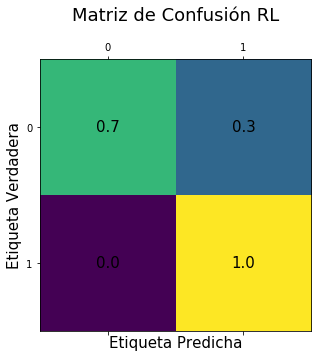

In [110]:
cm = confusion_matrix(y_test, y_predict_lr, normalize = 'true')

fig, ax = plt.subplots(figsize = (5, 5))
ax.matshow(cm)
plt.title('Matriz de Confusión RL', fontsize = 18, y = 1.12)
plt.ylabel('Etiqueta Verdadera', fontsize = 15)
plt.xlabel('Etiqueta Predicha', fontsize = 15)
for (i, j), z in np.ndenumerate(cm):
    ax.text(j, i, '{:0.1f}'.format(z), ha = 'center', va = 'center', fontsize = 15)
plt.savefig(fname = 'cm_lr.jpg', bbox_inches = 'tight', dpi = 200)
plt.show()

In [90]:
print(classification_report(y_test, y_predict_lr))

              precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       0.75      1.00      0.86         3

    accuracy                           0.83         6
   macro avg       0.88      0.83      0.83         6
weighted avg       0.88      0.83      0.83         6



In [91]:
param_grid_gNB = {'var_smoothing': np.logspace(0, -9, num = 100)
                }

In [92]:
gridsearch_gNB = GridSearchCV(estimator = GaussianNB(), param_grid = param_grid_gNB, n_jobs = -1, cv = 5, refit = True,
                              verbose = 2, return_train_score = True)

In [93]:
gridsearch_gNB.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


GridSearchCV(cv=5, estimator=GaussianNB(), n_jobs=-1,
             param_grid={'var_smoothing': array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2.31012970e-01,
       1.87381742e-01, 1.51991108e-01, 1.23284674e-01, 1.00000000e-01,
       8.11130831e-02, 6.57933225e-02, 5.33669923e-02, 4.32876128e-02,
       3.51119173e-02, 2.8480358...
       1.23284674e-07, 1.00000000e-07, 8.11130831e-08, 6.57933225e-08,
       5.33669923e-08, 4.32876128e-08, 3.51119173e-08, 2.84803587e-08,
       2.31012970e-08, 1.87381742e-08, 1.51991108e-08, 1.23284674e-08,
       1.00000000e-08, 8.11130831e-09, 6.57933225e-09, 5.33669923e-09,
       4.32876128e-09, 3.51119173e-09, 2.84803587e-09, 2.31012970e-09,
       1.87381742e-09, 1.51991108e-09, 1.23284674e-09, 1.00000000e-09])},
             return_train_score=True, verbose=2)

In [94]:
results_gNB = pd.DataFrame(gridsearch_gNB.cv_results_)
results_gNB = results_gNB.sort_values(by = 'rank_test_score')
results_gNB.head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_var_smoothing,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
11,0.001508,0.002162,0.000400,0.000799,0.1,{'var_smoothing': 0.1},1.0,1.0,0.333333,1.0,...,0.866667,0.266667,1,1.0,1.0,1.0,0.909091,0.916667,0.965152,0.042748
14,0.002852,0.005705,0.003251,0.006016,0.053367,{'var_smoothing': 0.0533669923120631},1.0,1.0,0.333333,1.0,...,0.866667,0.266667,1,1.0,1.0,1.0,0.909091,0.916667,0.965152,0.042748
13,0.000000,0.000000,0.000934,0.001867,0.065793,{'var_smoothing': 0.0657933224657568},1.0,1.0,0.333333,1.0,...,0.866667,0.266667,1,1.0,1.0,1.0,0.909091,0.916667,0.965152,0.042748


In [95]:
print(gridsearch_gNB.best_estimator_)

GaussianNB(var_smoothing=0.8111308307896871)


In [96]:
y_predict_gNB = gridsearch_gNB.predict(X_test)

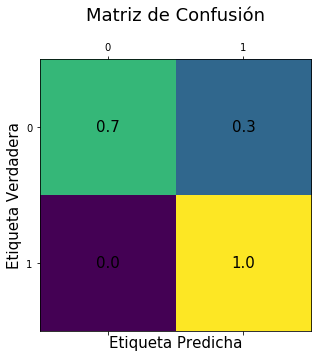

In [106]:
cm = confusion_matrix(y_test, y_predict_gNB, normalize = 'true')

fig, ax = plt.subplots(figsize = (5, 5))
ax.matshow(cm)
plt.title('Matriz de Confusión', fontsize = 18, y = 1.12)
plt.ylabel('Etiqueta Verdadera', fontsize = 15)
plt.xlabel('Etiqueta Predicha', fontsize = 15)
for (i, j), z in np.ndenumerate(cm):
    ax.text(j, i, '{:0.1f}'.format(z), ha = 'center', va = 'center', fontsize = 15)
plt.savefig(fname = 'cm_gNB.jpg', bbox_inches = 'tight', dpi = 200)
plt.show()

In [98]:
print(classification_report(y_test, y_predict_gNB))

              precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       0.75      1.00      0.86         3

    accuracy                           0.83         6
   macro avg       0.88      0.83      0.83         6
weighted avg       0.88      0.83      0.83         6

